<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/stats_models_for_finance_pt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install arch

In [ ]:
# Importing Python libraries
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
import scipy.stats as stats
import pylab
from arch.unitroot import ADF, KPSS
from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import UECM
from scipy.stats import kurtosis
from scipy.stats import skewnorm
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests

# **Challenge 1: Modelling Non-stationarity in a Time Series**

We reprise the dataset containing historical monthly closes for Apple (AAPL) stock from the dates of Jan 01, 2016 to Dec 31, 2021 for our modelling challenge (Yahoo, 2024). Subsequently, we hope to isolate stationary elements of this time series for modelling and analysis – as part of an analysis of price movements extending from Apple stock to big tech stocks in general, we eventually seek to cointegrate AAPL monthly closes with those of another major technology conglomerate, Amazon (AMZN) (Yahoo, 2024).

Our approach to selecting the best dataset does not include selecting from a series of
different datasets. Instead, having settled on the datasets to be used for comparison, we explore
options for cointegration by applying appropriate transformations to the data to produce derived
datasets which preserve the trends in the original datasets. We believe that this approach allows us
to compare the datasets accurately irrespective of the individual natures of the datasets, allowing us
to make a reliable decision on the potential of two chosen datasets for cointegration.

# **Data Curation and Preprocessing**

In [ ]:
# We can start with using the historical stock price of Apple (AAPL) from 2016 to 2021 inclusive as our time series
# Load the data
df = pd.read_csv('AAPL.csv')
# Print the first 5 rows to verify the data
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,25.6525,26.462500,23.097500,24.334999,22.096209,5087392000
1,2016-02-01,24.1175,24.722500,23.147499,24.172501,21.948658,3243450400
2,2016-03-01,24.4125,27.605000,24.355000,27.247499,24.875008,2984198400
3,2016-04-01,27.1950,28.097500,23.127501,23.434999,21.394478,3489534800
4,2016-05-01,23.4925,25.182501,22.367500,24.965000,22.791256,3602686000


As part of our preprocessing and transformation, we first plot the data to verify that its nature is that of a continuous time series. The plot of AAPL’s monthly closes against date is displayed below.

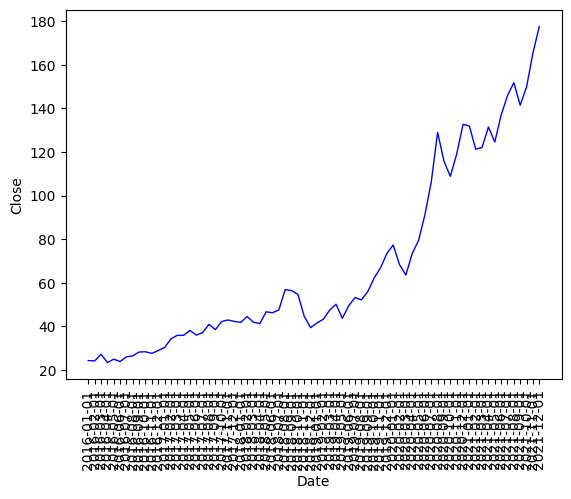

In [ ]:
# Let's visualize Apple's closing prices with date
aapl = df.loc[:, ["Date", "Close"]]
# Plot the data to visualize it
plt.plot(aapl.Date, aapl.Close, linewidth=1, c="b")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

The x-axis represents the exact date, while the y-axis represents the closing price.

Since our challenge involves finding a solution to reliably model a non-stationary time series, we inevitably start with profiling our data, i.e. assessing its stationarity. Let us use the Augmented Dickey-Fuller test, conducted at the 5% significance level, to do so. Applying it on our monthly AAPL closing prices gives us the following results:


In [ ]:
# AAPL Stock Price, ADF Test for unit root with Drift and Trend
adf = ADF(aapl["Close"], trend="ct", method="bic")
print("AAPL Augmented Dickey-Fuller Unit Root Test\n", adf.regression.summary())
print("\nTest statistics and critical values: \n", adf.summary())

AAPL Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     3.847
Date:                Thu, 27 Jun 2024   Prob (F-statistic):            0.00730
Time:                        08:24:00   Log-Likelihood:                -220.67
No. Observations:                  69   AIC:                             451.3
Df Residuals:                      64   BIC:                             462.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L

We observe that our p-value is 0.987, which exceeds the maximum threshold of 0.05 required to reject the null hypothesis. Our time series consisting of AAPL monthly closes from 2016 to 2021 therefore contains a unit root and is hence non-stationary. However, even if the time series formed by the monthly closes may not fulfil all aspects of stationarity, known as strict stationarity (where all joint probability density functions are stationarity irrespective of timeframe), it can still be weakly stationary (mean and variance remain unchanged with time). To determine which form of stationarity our time series satisfies (if any), we run the additional KPSS test, also at the 5% significance level, on our dataset. We obtain the following:

In [ ]:
# AAPL Stock Price, KPSS Test
KPSS(aapl["Close"], trend="ct", lags=-1)

Test Statistic,0.170
P-value,0.030
Lags,12


The KPSS test concludes with a p-value of 0.03, which means that we reject the null hypothesis and accept the alternative. In this case, our KPSS test results correspond with our ADF test results and so our time series of AAPL monthly closes meets no criteria for stationarity.

This means that we cannot use methods that assume stationarity to model historical AAPL monthly closes directly. However, we may be able to obtain a stationary time series by transforming the time series. We will next test a closely associated time series, the log transformation of the AAPL monthly closes, for stationarity. Before we conduct the test, we first plot this new time series to verify its continuity, as shown below:


<Axes: title={'center': 'AAPL Historical Closing Prices from 2016 to 2021'}, xlabel='Count', ylabel='Log Difference (AAPL)'>

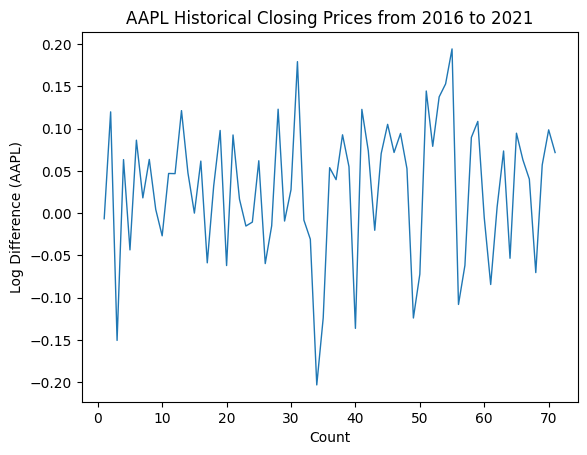

In [ ]:
# Let's plot the time series
laapl = np.log(aapl["Close"]).diff().dropna()
laapl.plot(linewidth=1, xlabel="Count", ylabel="Log Difference (AAPL)", title="AAPL Historical Closing Prices from 2016 to 2021")

We are hence dealing with a continuous time series. We can now repeat the ADF test on this new series to assess its stationarity. Conducting the test on this new series produces the following results:

In [ ]:
# ADF Test for AAPL logged difference with drift and trend - is it now stationary?
adf_log = ADF(laapl, trend="ct", method="bic")
print("Log-AAPL Augmented Dickey-Fuller Unit Root Test\n", adf_log.regression.summary())
print("\nTest statistics and critical values: \n", adf_log.summary())

Log-AAPL Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     31.96
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           1.80e-10
Time:                        08:24:01   Log-Likelihood:                 76.168
No. Observations:                  70   AIC:                            -146.3
Df Residuals:                      67   BIC:                            -139.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Lev

The log-transformed values of the AAPL monthly closes hence form a stationary time series that we can potentially use for our modelling challenge. As performed with the AAPL time series earlier, we also conduct the KPSS test for stationarity on this second time series to verify its stationarity.

In [ ]:
# Also conduct the KPSS Test again
KPSS(laapl, trend="ct", lags=-1)

Test Statistic,0.077
P-value,0.294
Lags,12


We thus now have a stationary time series in AAPL prices that can be modelled individually, and what remains is to use a statistical algorithm to model the series. However, we wish to extend our analysis beyond AAPL stock to track the movements of stock prices associated with other major companies in its sector of technology. Hence, we will not limit ourselves to AAPL monthly closes. Let us bring in a second time series, that of Amazon (AMZN) monthly closing prices, and explore the potential for the two time series to be cointegrated and analyzed.

In [ ]:
# Now that we know the series associated with AAPL stock prices that fulfil stationarity criteria, we can now try out cointegration with another
# stock - in this case let's use Amazon stock
# Load the data
df_a = pd.read_csv('AMZN.csv')
# Print the first 5 rows to verify the data
df_a.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,32.814499,32.886002,27.358999,29.350000,29.350000,2604018000
1,2016-02-01,28.907499,29.090000,23.700001,27.625999,27.625999,2482896000
2,2016-03-01,27.814501,30.162001,26.929001,29.681999,29.681999,1880190000
3,2016-04-01,29.524500,33.499001,29.262501,32.979500,32.979500,1569284000
4,2016-05-01,33.195999,36.211498,32.799999,36.139500,36.139500,1812290000


The tests we performed on the AAPL monthly closes earlier will also be performed on AMZN monthly closes. We start by visualizing the trend in Amazon’s closes alongside Apple’s closes, as shown below:

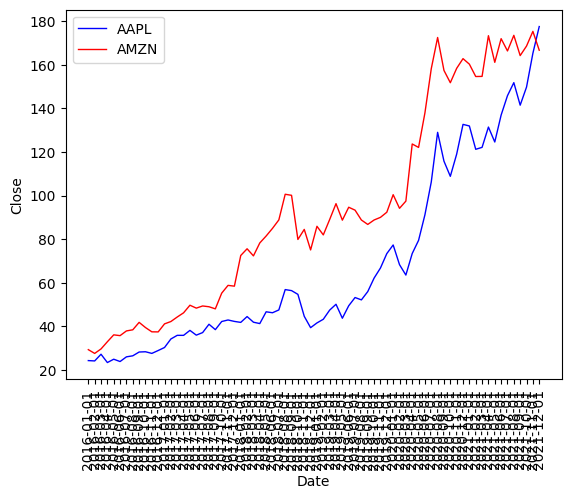

In [ ]:
# Extract just the date and closing price for AMZN historical data
amzn = df_a.loc[:, ["Date", "Close"]]
# Plot AAPL and AMZN stock price closes alongside each other
plt.plot(aapl["Date"], aapl["Close"], linewidth=1, c="b", label="AAPL")
plt.plot(amzn["Date"], amzn["Close"], linewidth=1, c="r", label="AMZN")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()

Noting that both time series are continuous and share the same timeframe, we may explore several related time series comparing the two stocks for potential analysis. As an extension of this challenge, let us also visualize the difference in closing prices between Apple and Amazon’s stocks:

<Axes: title={'center': 'Difference between AAPL and AMZN Historical Closing Prices from 2016 to 2021'}, xlabel='Count', ylabel='Difference'>

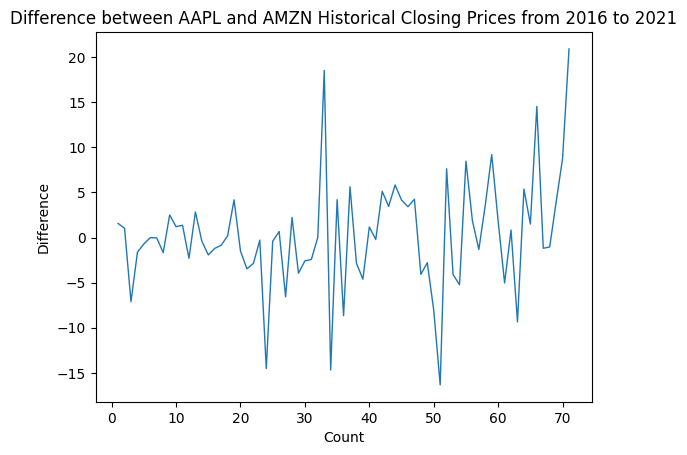

In [ ]:
# Calculate and assign to a variable the difference in closing price between AAPL and AMZN stock - optional series
aapl_d = aapl.Close.diff().dropna()
amzn_d = amzn.Close.diff().dropna()
diff = aapl_d - amzn_d
# Plot the difference in closing price between AAPL and AMZN stock - optional
diff.plot(linewidth=1, xlabel="Count", ylabel="Difference", title="Difference between AAPL and AMZN Historical Closing Prices from 2016 to 2021")

Noting the similarity in shape to the log-transformed AAPL monthly closes visualized earlier, this time series is likely to be stationary as well. The analyst has the option of conducting the ADF and KPSS tests on this series to verify that this is the case – if so, we would have obtained an additional time series strongly correlated with price movements in both stocks for analysis; a valuable time series to use if one is modelling co-movements in both stocks. However, we will not explore this time series further to avoid detraction from our goal of cointegrating AAPL and AMZN time series for analysis.

We now have to repeat the ADF and KPSS tests on the AMZN monthly closes. Doing so gives us the following results:


In [ ]:
# Check for cointegration of the two time series using the Engle-Granger (EG) Two-Step Test
# We checked that AAPL was non-stationary earlier. Now we check AMZN stock data with drift and trend using ADF
adf = ADF(amzn["Close"], trend="ct", method="bic")
print("AMZN Augmented Dickey-Fuller Unit Root Test\n", adf.regression.summary())
print("\nTest statistics and critical values: \n", adf.summary())

AMZN Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.402
Date:                Thu, 27 Jun 2024   Prob (F-statistic):             0.0391
Time:                        08:24:02   Log-Likelihood:                -241.90
No. Observations:                  71   AIC:                             489.8
Df Residuals:                      68   BIC:                             496.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L

In [ ]:
KPSS(amzn["Close"], trend="ct", lags=-1)

Test Statistic,0.110
P-value,0.126
Lags,12


To give us more options as to series we can potentially use for cointegration and modelling, we repeat the ADF and KPSS tests on the first differences of AAPL and AMZN's monthly closes as well:

In [ ]:
# Repeat the ADF tests for the first differences of the two series - Optional
aapl_diff = ADF(aapl_d, trend="n", method="bic")
print("AAPL Diff Augmented Dickey-Fuller Unit Root Test\n", aapl_diff.regression.summary())
print("\nTest statistics and critical values: \n", aapl_diff.summary())
amzn_diff = ADF(amzn_d, trend="n", method="bic")
print("AMZN Diff Augmented Dickey-Fuller Unit Root Test\n", amzn_diff.regression.summary())
print("\nTest statistics and critical values: \n", amzn_diff.summary())

AAPL Diff Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.368
Model:                            OLS   Adj. R-squared (uncentered):              0.359
Method:                 Least Squares   F-statistic:                              40.17
Date:                Thu, 27 Jun 2024   Prob (F-statistic):                    2.06e-08
Time:                        08:24:02   Log-Likelihood:                         -232.63
No. Observations:                  70   AIC:                                      467.3
Df Residuals:                      69   BIC:                                      469.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

We thus have two additional options to choose from when selecting time series to model to analyze the movements and co-movements of Apple and Amazon shares. Let us conclude the earlier investigation into the suitability of directly applying stationary series modelling methods to AAPL and AMZN monthly closes. We do so by running the Phillips Ouliaris Test for Cointegration to assess if the two series are cointegrated.

In [ ]:
# Finally, perform the Two-Step Test for Cointegration (Phillips and Ouliaris Cointegration Test)
phillips_ouliaris(aapl["Close"], amzn["Close"], trend="c", test_type="Za", kernel="bartlett")

Test Statistic,-0.521
P-value,0.810
Kernel,Bartlett
Bandwidth,1.989


The $p$-value of our Phillips-Ouliaris Test is 0.810, which is greater than the minimum threshold of 0.05 required for us to reject the null hypothesis. Hence, AAPL and AMZN monthly closes cannot be integrated directly. We will have to explore transformed time series associated with these shares for their potential to be cointegrated.

As we did with the AAPL monthly closes earlier, we first explore the log-transformed AMZN monthly close values. Plotting the series, we have

<Axes: title={'center': 'AMZN Historical Closing Prices from 2016 to 2021'}, xlabel='Count', ylabel='Log Difference (AAPL)'>

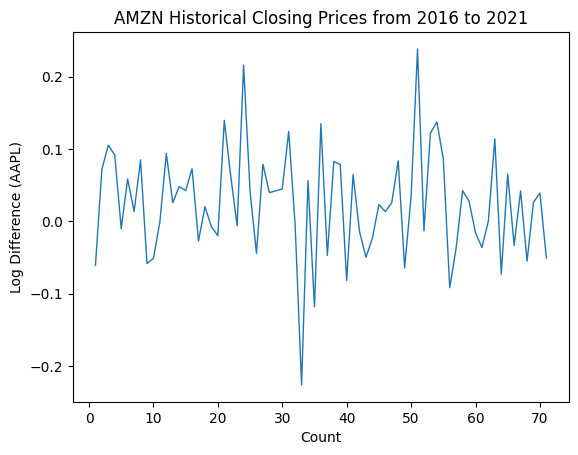

In [ ]:
# Will the log transform of the AMZN monthly closes be stationary? Let's repeat what we did with AAPL closes to AMZN closes
lamzn = np.log(amzn["Close"]).diff().dropna()
lamzn.plot(linewidth=1, xlabel="Count", ylabel="Log Difference (AAPL)", title="AMZN Historical Closing Prices from 2016 to 2021")

while conducting the ADF and KPSS tests on the log-transformed AMZN monthly closes yields for us the following results:

In [ ]:
# ADF Test for AAPL logged difference with drift and trend - is it now stationary?
adf_log = ADF(lamzn, trend="ct", method="bic")
print("Log-AMZN Augmented Dickey-Fuller Unit Root Test\n", adf_log.regression.summary())
print("\nTest statistics and critical values: \n", adf_log.summary())

Log-AMZN Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     46.60
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           2.08e-13
Time:                        08:24:05   Log-Likelihood:                 83.697
No. Observations:                  70   AIC:                            -161.4
Df Residuals:                      67   BIC:                            -154.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Lev

In [ ]:
# Also conduct the KPSS Test again
KPSS(lamzn, trend="ct", lags=-1)

Test Statistic,0.066
P-value,0.390
Lags,12


In this case, the results of the ADF and KPSS tests agree that the log-transformed AMZN monthly closing price values form a stationary time series suitable for use alongside the log-transformed AAPL monthly closing price values. Given that both series are stationary, a linear combination of them would also produce a stationary time series and hence, both series will be cointegrated. As a formality, however, we conclude on their cointegrated nature by conducting the Phillips-Ouliaris Test for Cointegration on the log-transformed AAPL and AMZN monthly close values at the 5% significance level. Our results give us a p-value of 0, showing that we can reject the null hypothesis in favour of the alternative hypothesis that the two series are cointegrated.

In [ ]:
# Repeat the Phillips and Ouliaris Cointegration Test for the log transforms of AAPL and AMZN closes
phillips_ouliaris(laapl, lamzn, trend="c", test_type="Za", kernel="bartlett")

Test Statistic,-57.236
P-value,0.000
Kernel,Bartlett
Bandwidth,9.736


This concludes the data curation and preprocessing phase of our challenge. In the next section, we proceed to set up our model to analyze the two time series.

# **Model Calibration and Explanation of Parameters**

Having a pair of cointegrated time series at hand, we now aim to compare the co-movements in the time series over an extended time horizon. A suitable model to use for doing so is the Error Correction Model, which we run in this case taking the log-transformed AAPL monthly closes as the endogenous (dependent) variable and the log-transformed AMZN monthly closes as the exogenous (independent) variable. Implementing the model yields us the following table.

In [ ]:
# We now have a pair of stationary time series at hand to model. Let's use the Error Correction Model (ECM) to do so
ecm_model = UECM(endog=pd.DataFrame(laapl), lags=1, exog=pd.DataFrame(lamzn), order=1, trend="c").fit() # U - Unconstrained
ecm_model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              UECM Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                   71
Model:                     UECM(1, 1)   Log Likelihood                  87.597
Method:               Conditional MLE   S.D. of innovations              0.111
Date:                Thu, 27 Jun 2024   AIC                           -165.195
Time:                        08:24:05   BIC                           -153.953
Sample:                             1   HQIC                          -160.729
                                   71                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.010      0.851      0.398      -0.011       0.028
Close.L1      -0.9859      0.122     -8.081      0.000      -1.229      -0.742
Close.L1       0.7708      0.184      4.195      0.000       0.404       1.138
D.Close.L0     0.5793      0.116      5.010      0.000       0.348       0.810
==============================================================================
"""

The results suggest strong correlation between AAPL and AMZN stocks. In particular, the L1 value for the log-transformed AAPL monthly close values is -0.9859, indicating that a deviation in its value from the long-term equilibrium with the log-transformed AMZN monthly closes by 1 at a given time step will be followed by a drop of 0.9859 points in the next time step. In this case, the drop almost completely compensates for any deviation in value. However, the AIC and BIC scores are high, indicating that this model does not capture the scale of correlation completely. The analyst is encouraged to conduct the Error Correction Model using alternative time series associated with AAPL and AMZN stocks, such as the differences in their closing values that was visualized earlier.

Finally, we run the Durbin-Watson test to check for autocorrelation in the residuals:

In [ ]:
# Finally, we use the Durbin-Watson Test to check for autocorrelation in the residuals
durbin_watson(ecm_model.fittedvalues)

2.1186293975496207

Unfortunately, in this case, we get a value of 2.11, suggesting a negative autocorrelation in the log-transformed AAPL monthly close values (Kenton, 2024) which makes deeper analysis more complex. Our assessment of the correlation between AAPL and AMZN monthly closing prices thus has to consider autocorrelated movements in AAPL close prices as well.

# **Challenge 2: Detecting and Adapting to Regime Changes in Time Series**

Our chosen dataset for this challenge is a dataset containing historical real GDP data of the United States from the year 1947 to the present day (2024), obtained from the official St. Louis Federal Reserve (FRED) database (FRED, 2024). This dataset was chosen as its long timeframe and pockets of irregular (virtually stochastic) movements suggested to us that the distribution modelling its contents would not be static for the entire timeframe.

# **Data Curation and Preprocessing**

As with the first challenge, we do not decide the dataset to be used for modelling on an a posteriori basis following analysis of properties such as its stationarity and potential for cointegration. Instead, we opt to apply statistical transformations to data that is non-stationary in nature to produce derived datasets that can be modelled with our chosen modelling strategy, allowing us to model the time series and hence regime changes in the data while minimizing distortion in trends reflected in the dataset.

In [ ]:
# Let's use US GDP data from 1947 to the present
gdp_data = pd.read_csv("GDPC1.csv").dropna()
# Display the first 5 rows of the data to verify correct loading of the dataset
gdp_data.head()

,DATE,GDPC1
0,1947-01-01,2182.681
1,1947-04-01,2176.892
2,1947-07-01,2172.432
3,1947-10-01,2206.452
4,1948-01-01,2239.682


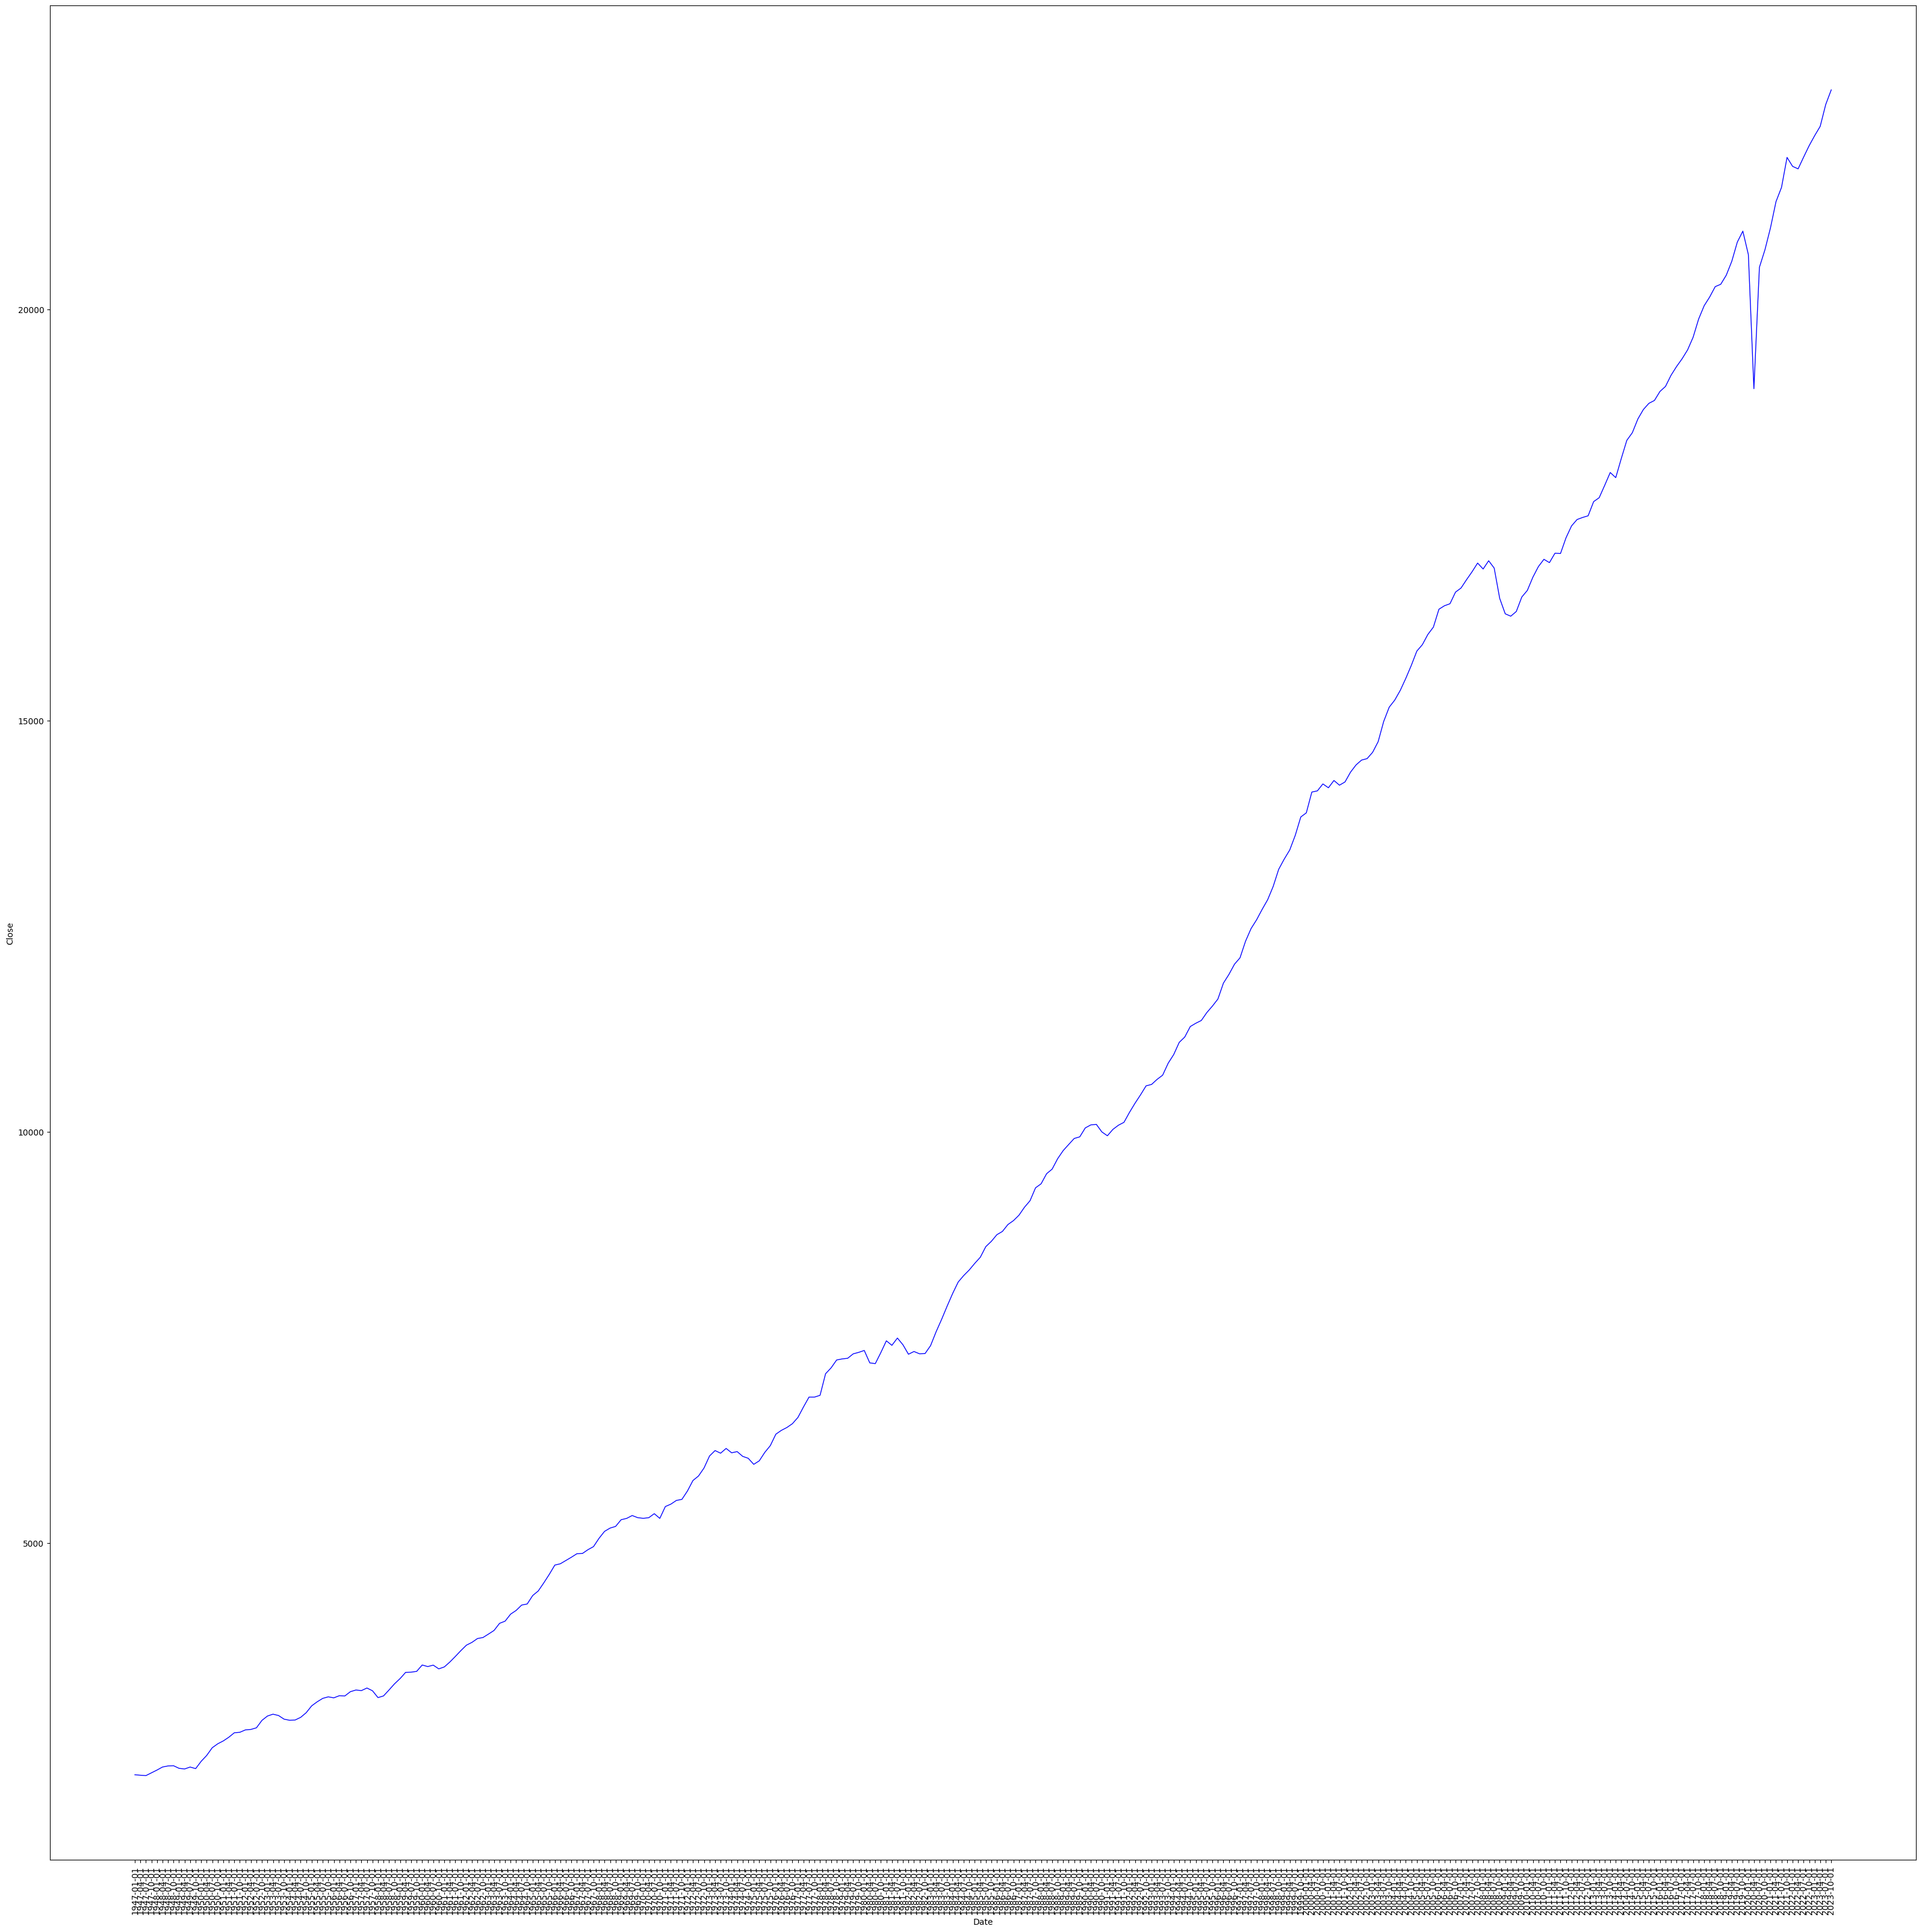

In [ ]:
# Plot the data to visualize it
plt.figure(figsize=(40,40))
plt.plot(gdp_data['DATE'], gdp_data['GDPC1'], linewidth=1, c="b", label="US GDP Data (1947-2022)")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

# **Model Calibration and Explanation of Parameters**

Having outlined the mathematical expression for the Markov-Switching Autoregressive Model of order 4 in the section describing our general modelling strategy for this challenge, we implement it programmatically on this dataset. In our case, it is not certain as to which regression best characterizes the movement in historical US GDP data, so we implement our Markov-Switching AR(4) model on the US GDP data and its first difference, as well as on their log-transformed values, giving us 4 time series to model. Modelling each time series yields the following results.

In [ ]:
# Create the Markov Autoregressive Model - to simplify the analysis we turn off switching coefficients phi_1 to phi_4 in the formula
# by setting switching_ar=False
switch_model_markovar = sm.tsa.MarkovAutoregression(gdp_data['GDPC1'].dropna(), k_regimes=2, order=4, switching_ar=False)
res = switch_model_markovar.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/tools.py:544: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/tools.py:503: RuntimeWarning: invalid value encountered in divide
  r = unconstrained/((1 + unconstrained**2)**0.5)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    GDPC1   No. Observations:                  304
Model:             MarkovAutoregression   Log Likelihood                     nan
Date:                  Thu, 27 Jun 2024   AIC                                nan
Time:                          08:24:10   BIC                                nan
Sample:                               0   HQIC                               nan
                                  - 304                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.004e+04        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.01e+04        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.472e+04        nan        nan        nan         nan         nan
ar.L1             nan        nan        nan        nan         nan         nan
ar.L2             nan        nan        nan        nan         nan         nan
ar.L3             nan        nan        nan        nan         nan         nan
ar.L4         -0.1994        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5010        nan        nan        nan         nan         nan
p[1->0]        0.4962        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix is singular or near-singular, with condition number    nan. Standard errors may be unstable.
"""

In [ ]:
# Create the Markov Autoregressive Model - to simplify the analysis we turn off switching coefficients phi_1 to phi_4 in the formula
# by setting switching_ar=False
switch_model_markovar = sm.tsa.MarkovAutoregression(np.log(gdp_data['GDPC1']).dropna(), k_regimes=2, order=4, switching_ar=False)
res = switch_model_markovar.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    GDPC1   No. Observations:                  304
Model:             MarkovAutoregression   Log Likelihood                1014.482
Date:                  Thu, 27 Jun 2024   AIC                          -2010.964
Time:                          08:24:17   BIC                          -1977.510
Sample:                               0   HQIC                         -1997.582
                                  - 304                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0093      1.336      8.990      0.000       9.391      14.627
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0862      1.336      9.048      0.000       9.468      14.704
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.075e-05   5.74e-06     12.329      0.000    5.95e-05     8.2e-05
ar.L1          1.3207      0.057     23.217      0.000       1.209       1.432
ar.L2         -0.1872      0.094     -1.998      0.046      -0.371      -0.004
ar.L3         -0.2710      0.093     -2.902      0.004      -0.454      -0.088
ar.L4          0.1359      0.056      2.411      0.016       0.025       0.246
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     1.136e-57        nan        nan        nan         nan         nan
p[1->0]        0.0033      0.003      1.002      0.317      -0.003       0.010
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
# Create the Markov Autoregressive Model - to simplify the analysis we turn off switching coefficients phi_1 to phi_4 in the formula
# by setting switching_ar=False
switch_model_markovar = sm.tsa.MarkovAutoregression(gdp_data['GDPC1'].diff().dropna(), k_regimes=2, order=4, switching_ar=False)
res = switch_model_markovar.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    GDPC1   No. Observations:                  303
Model:             MarkovAutoregression   Log Likelihood               -1945.033
Date:                  Thu, 27 Jun 2024   AIC                           3908.066
Time:                          08:24:22   BIC                           3941.490
Sample:                               0   HQIC                          3921.438
                                  - 303                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.6366     10.809      3.760      0.000      19.452      61.821
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.6462     11.826      7.919      0.000      70.468     116.825
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.153e+04   1789.061     12.032      0.000     1.8e+04     2.5e+04
ar.L1         -0.1615      0.059     -2.724      0.006      -0.278      -0.045
ar.L2         -0.0638      0.060     -1.059      0.290      -0.182       0.054
ar.L3         -0.0342      0.060     -0.570      0.569      -0.152       0.083
ar.L4         -0.0449      0.059     -0.765      0.444      -0.160       0.070
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9948      0.008    123.064      0.000       0.979       1.011
p[1->0]        0.0051      0.008      0.612      0.541      -0.011       0.022
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
# Create the Markov Autoregressive Model - to simplify the analysis we turn off switching coefficients phi_1 to phi_4 in the formula
# by setting switching_ar=False
# Let's use the log transform of the data to do the regime change
switch_model_markovar = sm.tsa.MarkovAutoregression(np.log(gdp_data['GDPC1']).diff().dropna(), k_regimes=2, order=4, switching_ar=False)
res = switch_model_markovar.fit()
res.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    GDPC1   No. Observations:                  303
Model:             MarkovAutoregression   Log Likelihood                 935.593
Date:                  Thu, 27 Jun 2024   AIC                          -1853.186
Time:                          08:24:25   BIC                          -1819.762
Sample:                               0   HQIC                         -1839.814
                                  - 303                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.007      1.154      0.248      -0.005       0.021
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0074        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   9.99e-06     12.185      0.000       0.000       0.000
ar.L1          0.1194      0.058      2.064      0.039       0.006       0.233
ar.L2          0.1117      0.058      1.938      0.053      -0.001       0.225
ar.L3         -0.0215      0.058     -0.373      0.710      -0.134       0.091
ar.L4         -0.0673      0.057     -1.178      0.239      -0.179       0.045
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4767      9.377      0.051      0.959     -17.902      18.856
p[1->0]        0.4623      8.737      0.053      0.958     -16.662      17.587
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

From Figure 4, based on an AR(4) representation of the data, historical GDP values in the US from 1928 to the present day can be split into two regimes. Comparing the results of the 4 models gives us a clear choice in using the AR(4) model that was run on the log-transformed first differences of US GDP data as it is the only model that has finite values for all its parameters. However, the high AIC and BIC values indicate that the model should be refined to provide a more reflective picture of the effects of regime change and state transitions on the model distribution and hence regression.

In this case, it is more likely than not that an AR(4) process does not give us the function needed that best describes the process, resulting in the high information leakage represented by the high AIC and BIC scores. In practice, this means that the analyst needs to reconceive the model; more specifically, what p-value to use so as to produce an AR(p) model which reflects the trends in historical US GDP data more closely.

# **References**

FRED. (2024, March 28). Real Gross Domestic Product . Retrieved from FRED: https://fred.stlouisfed.org/series/GDPC1

Hamilton, J. D. (1989). A New Approach to the Economic Analysis of Nonstationary Time Series and the Business Cycle. Econometrica, 357-384. Retrieved from statsmodels.org.

Kenton, W. (2024, May 31). Durbin Watson Test: What It Is in Statistics, With Examples. Retrieved from Investopedia: https://www.investopedia.com/terms/d/durbin-watson-statistic.asp#:~:text=Key%20Takeaways,above%202.0%20indicates%20negative%20autocorrelation.

Yahoo. (2024, June 1). AAPL. Retrieved from Yahoo Finance: https://finance.yahoo.com/quote/AAPL/history/?period1=1451606400&period2=1640908800&interval=1mo&filter=history&frequency=1mo

Yahoo. (2024, June 1). AMZN. Retrieved from Yahoo Finance: https://finance.yahoo.com/quote/AMZN/history/?frequency=1mo

